In [ ]:
import zipfile as zf
files = zf.ZipFile("0.zip", 'r')
files.extractall('./woodslabs/train')
files.extractall('./woodslabs/valid')
files.extractall('./woodslabs/test')

files = zf.ZipFile("1.zip", 'r')
files.extractall('./woodslabs/train')
files.extractall('./woodslabs/valid')
files.extractall('./woodslabs/test')

files.close()

In [17]:
import zipfile as zf
files = zf.ZipFile("2.zip", 'r')
files.extractall('./woodslabs/2')

files.close()

In [ ]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import time
import os 
from PIL import Image
import torch
import numpy as np
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [2]:
data_dir = 'woodslabs'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

device = 'cuda'

In [3]:
# TODO: Define your transforms for the training, validation, and testing sets
train_transform = transforms.Compose([transforms.RandomRotation(45),
                                     transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.RandomVerticalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

valid_transform = transforms.Compose([transforms.Resize([224, 224]),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

test_transform = transforms.Compose([transforms.Resize([224, 224]),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

# print(train_transform)

# TODO: Load the datasets with ImageFolder
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
valid_dataset = datasets.ImageFolder(valid_dir, transform=valid_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)

# print(train_dataset)

# TODO: Using the image datasets and the trainforms, define the dataloaders
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=8, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=8)

# print(train_dataloader)

class_to_idx = train_dataset.class_to_idx
# print(class_to_idx)


# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

In [4]:
# TODO: Build and train your network
model = models.vgg16(pretrained=True)
print(model)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:04<00:00, 121237659.70it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [5]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict

classifier = nn.Sequential(OrderedDict([
                            ('inputs', nn.Linear(25088, 4096, bias=True)),
                            ('relu1', nn.ReLU()),
                            ('do1',nn.Dropout(0.5)),    
                            ('hidden_layer1',nn.Linear(4096, 2)),
                            ('output', nn.LogSoftmax(dim=1))
                              ]))

model.classifier = classifier
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
model.to(device)

model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [6]:
# Implement a function for the validation pass
def validation(model, dataloader, criterion):
    loss = 0
    accuracy = 0
    
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        output = model.forward(images)
        loss += criterion(output, labels).item()

        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return loss, accuracy

In [7]:
epochs = 3
steps = 0
running_loss = 0
print_every = 5

for e in range(epochs):
    model.train()
    for images, labels in train_dataloader:
        steps += 1
        
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        output = model.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            # Make sure network is in eval mode for inference
            model.eval()
            
            # Turn off gradients for validation, saves memory and computations
            with torch.no_grad():
                valid_loss, accuracy = validation(model, valid_dataloader, criterion)
                
            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                  "Validation Loss: {:.3f}.. ".format(valid_loss/len(valid_dataloader)),
                  "Validation Accuracy: {:.3f}".format(accuracy/len(valid_dataloader)))
            
            running_loss = 0
            
            # Make sure training is back on
            model.train()
    

Epoch: 1/3..  Training Loss: 4.694..  Validation Loss: 0.645..  Validation Accuracy: 0.919
Epoch: 1/3..  Training Loss: 1.794..  Validation Loss: 5.894..  Validation Accuracy: 0.712
Epoch: 1/3..  Training Loss: 3.432..  Validation Loss: 4.105..  Validation Accuracy: 0.725
Epoch: 1/3..  Training Loss: 3.006..  Validation Loss: 2.039..  Validation Accuracy: 0.894
Epoch: 2/3..  Training Loss: 3.494..  Validation Loss: 1.968..  Validation Accuracy: 0.913
Epoch: 2/3..  Training Loss: 3.149..  Validation Loss: 2.801..  Validation Accuracy: 0.856
Epoch: 2/3..  Training Loss: 1.228..  Validation Loss: 3.367..  Validation Accuracy: 0.875
Epoch: 2/3..  Training Loss: 1.924..  Validation Loss: 1.678..  Validation Accuracy: 0.925
Epoch: 3/3..  Training Loss: 0.599..  Validation Loss: 5.056..  Validation Accuracy: 0.775
Epoch: 3/3..  Training Loss: 3.976..  Validation Loss: 1.640..  Validation Accuracy: 0.938
Epoch: 3/3..  Training Loss: 2.170..  Validation Loss: 1.363..  Validation Accuracy: 0.925

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [8]:
# TODO: Do validation on the test set
correct = 0
total = 0

model.eval()
model.to(device)

with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        predicted = torch.max(outputs.data, 1)[1]
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on test images: %d %%' % (100 * correct / total))

Accuracy of the network on test images: 92 %


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [9]:
# TODO: Save the checkpoint
def save_checkpoint(path = 'chkp_woodslabs.pth'):
    model.class_to_idx = class_to_idx
    
    torch.save({
                    'model' : model,
                    'classifier': model.classifier,
                    'class_to_idx': model.class_to_idx,
                    'state': model.state_dict(),
                    'optimizer': optimizer.state_dict()        
                },
                path)

In [10]:
model.class_to_idx = train_dataset.class_to_idx

save_checkpoint()

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [4]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(path = 'chkp_woodslabs.pth'):
    checkpoint = torch.load(path, map_location=lambda storage, loc: storage)
    
    model = checkpoint['model']
    model.classifier = checkpoint['classifier']
    model.load_state_dict(checkpoint['state'])
    model.class_to_idx = checkpoint['class_to_idx']
    optimizer = checkpoint['optimizer']
    
    model.to(device)
    
    for param in model.parameters():
        param.requires_grad = False
    
    return model

In [5]:
model = load_checkpoint()

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [6]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    image_res = Image.open(image)
    processed_image = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                     std=[0.229, 0.224, 0.225])
    ])
    
    return processed_image(image_res)

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [7]:
def imshow(image, ax, title=None):
    image = image.numpy().transpose((1, 2, 0))
    
    image = np.array([0.229, 0.224, 0.225]) * image + np.array([0.485, 0.456, 0.406])
    
    image = np.clip(image, 0, 1)
    
    ax.axis('off')
    
    if(title):
        ax.set_title(title)
    
    ax.imshow(image)
    
    return ax

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [8]:
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [11]:
def predict(image_path, model, top_k=1):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    model.to(device)
    img_torch = process_image(image_path)
    img_torch = img_torch.unsqueeze_(0)
    img_torch = img_torch.float()
    
    with torch.no_grad():
        if device == 'cuda':
            output = model.forward(img_torch.cuda())
        else:
            output = model.forward(img_torch.cpu())
        probs = torch.exp(output)
        
#         print(f'probs: {probs}')
        
    top_probs, top_idxs = probs.topk(top_k)
        
    return probs, top_probs, top_idxs

In [9]:
def predict2(image_path, model, print_time=False):
    if(print_time):
        t1 = time.time()
    
    img_torch = process_image(image_path)
    img_torch = img_torch.unsqueeze_(0)
    img_torch = img_torch.float()
    
    with torch.no_grad():
        if device == 'cuda':
            output = model.forward(img_torch.cuda())
        else:
            output = model.forward(img_torch.cpu())
        probs = torch.exp(output)
        
    if(print_time):
        t2 = time.time()        
        tot_time = t2 - t1
        print(tot_time)
        
    return probs

In [12]:
def get_predictions(image_path):
    _, top_probs, top_idxs = predict(image_path, model)
    
#     print(f'top_probs: {top_probs}')
#     print(f'top_idxs: {top_idxs}')
    
    probs = top_probs.tolist()[0]
    idxs = top_idxs.tolist()[0]
    
    idx_to_class = {model.class_to_idx[i] : i for i in model.class_to_idx}
  
    classes = []   
    for i in range(len(idxs)):
#         print(str(idxs[i]))
        classes.append(cat_to_name[idx_to_class[idxs[i]]])
    
    return probs, classes

In [13]:
# TODO: Display an image along with the top 5 classes
def check_sanity(probs, classes, top_k=1):    
    f = plt.figure(figsize=(10, 15))
    ax1 = f.add_subplot(2, 1, 1)
    ax2 = f.add_subplot(2, 1, 2)
    
    ax1 = imshow(process_image(image_path), ax1, 'Input Image')  
    
    ax2.set_title('Predictions')
    ax2.set_xlabel('Probability, %')

#     probs = [prob * 100 for prob in probs]   
#     print(probs)
#     ax2.barh(-np.arange(top_k), width=probs, tick_label=classes, color='g')

    

    plt.tight_layout()    
    plt.show()

In [10]:
def check_sanity2(probs):    
    f = plt.figure(figsize=(5, 5))
    ax1 = f.add_subplot(2, 1, 1)   
    ax1 = imshow(process_image(image_path), ax1, 'Input Image')   

    plt.tight_layout()    
    plt.show()
  
    probs = [prob * 100 for prob in probs]
    
    print('prob of NO CRACKS on the image: %.2f' % probs[0][0] + '%')
    print('prob of CRACKS on the image: %.2f' %probs[0][1] + '%')
    
#     print(f'prob of NO CRACKS on the image: {probs[0][0]}%')
#     print(f'prob of CRACKS on the image: {probs[0][1]}%')

0.02127552032470703


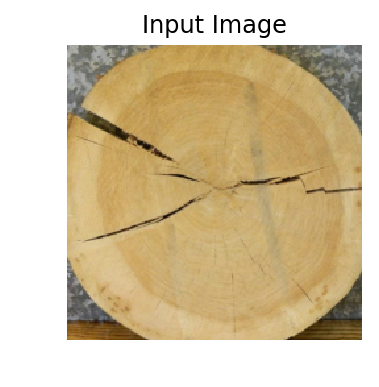

prob of NO CRACKS on the image: 0.00%
prob of CRACKS on the image: 100.00%


In [14]:
image_path = './woodslabs/train/1/4.jpeg' # 'test_image.jpg'

check_sanity2(predict2(image_path, model, print_time=True))

0.07515764236450195


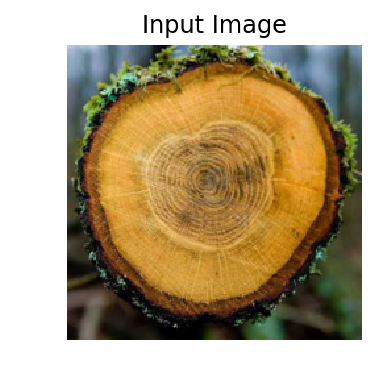

prob of NO CRACKS on the image: 100.00%
prob of CRACKS on the image: 0.00%
0.015623807907104492


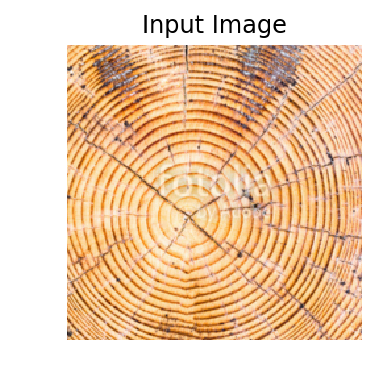

prob of NO CRACKS on the image: 0.00%
prob of CRACKS on the image: 100.00%
0.013609647750854492


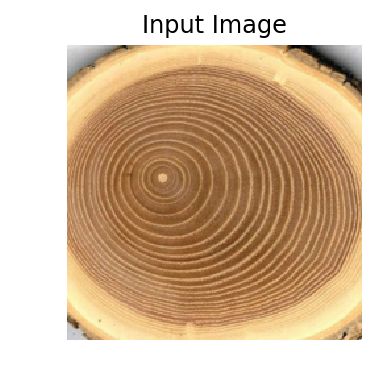

prob of NO CRACKS on the image: 100.00%
prob of CRACKS on the image: 0.00%
0.06175684928894043


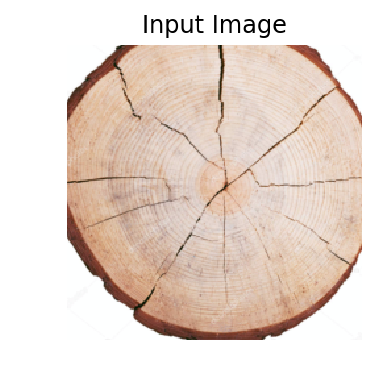

prob of NO CRACKS on the image: 0.00%
prob of CRACKS on the image: 100.00%
0.017360925674438477


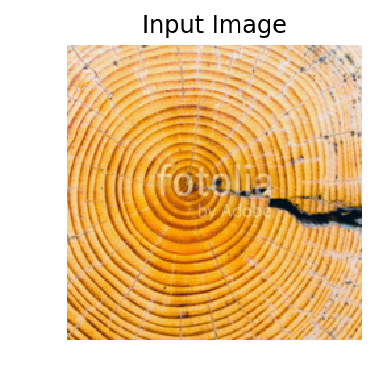

prob of NO CRACKS on the image: 100.00%
prob of CRACKS on the image: 0.00%
0.015577554702758789


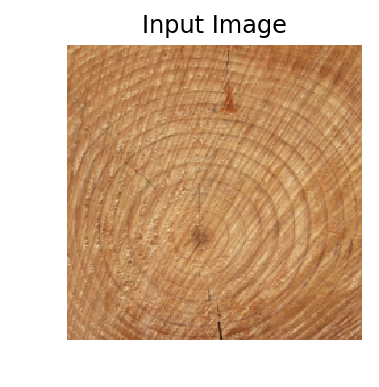

prob of NO CRACKS on the image: 14.61%
prob of CRACKS on the image: 85.39%
0.01009988784790039


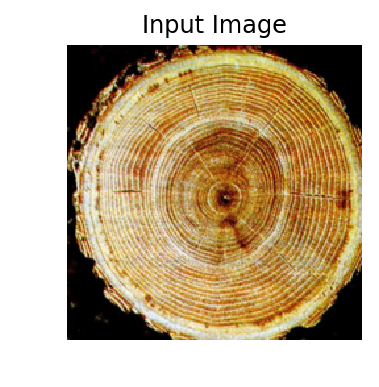

prob of NO CRACKS on the image: 99.99%
prob of CRACKS on the image: 0.01%
0.015042543411254883


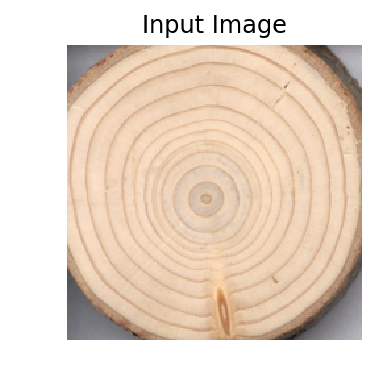

prob of NO CRACKS on the image: 100.00%
prob of CRACKS on the image: 0.00%
0.018794775009155273


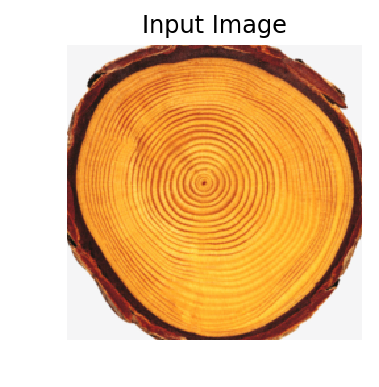

prob of NO CRACKS on the image: 100.00%
prob of CRACKS on the image: 0.00%
0.007756710052490234


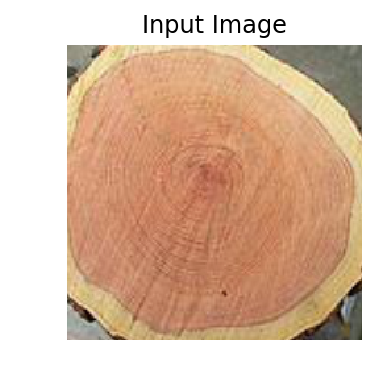

prob of NO CRACKS on the image: 0.11%
prob of CRACKS on the image: 99.89%
0.013126134872436523


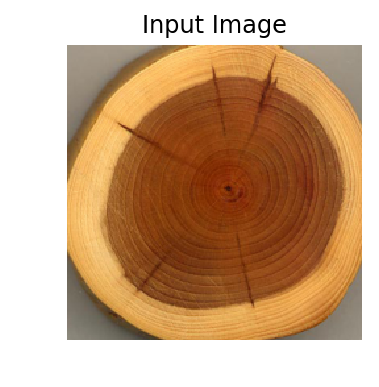

prob of NO CRACKS on the image: 81.58%
prob of CRACKS on the image: 18.42%
0.008923053741455078


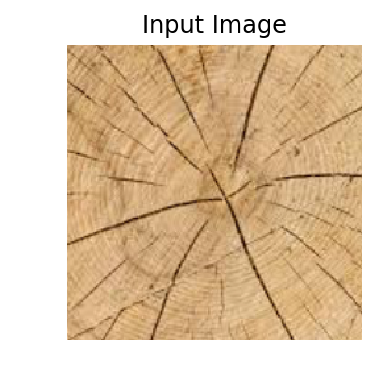

prob of NO CRACKS on the image: 0.00%
prob of CRACKS on the image: 100.00%
0.015037298202514648


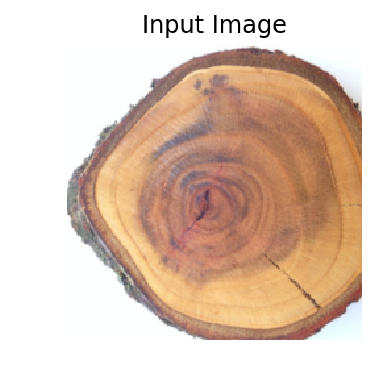

prob of NO CRACKS on the image: 56.40%
prob of CRACKS on the image: 43.60%
0.014826059341430664


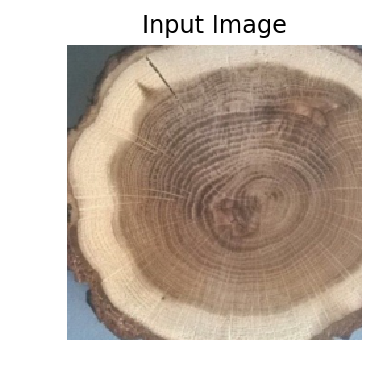

prob of NO CRACKS on the image: 0.00%
prob of CRACKS on the image: 100.00%
0.056394100189208984


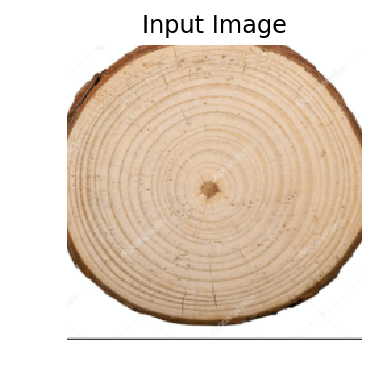

prob of NO CRACKS on the image: 0.00%
prob of CRACKS on the image: 100.00%
0.014592885971069336


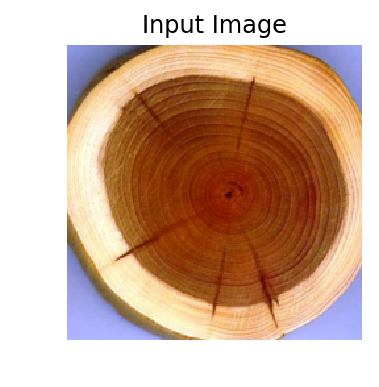

prob of NO CRACKS on the image: 99.99%
prob of CRACKS on the image: 0.01%
0.012724876403808594


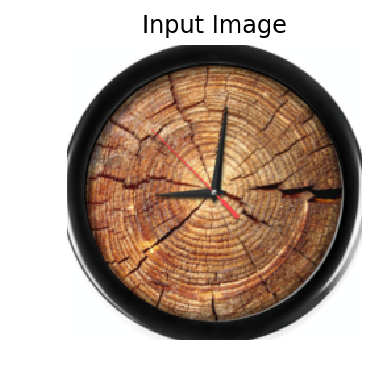

prob of NO CRACKS on the image: 0.00%
prob of CRACKS on the image: 100.00%
0.05091977119445801


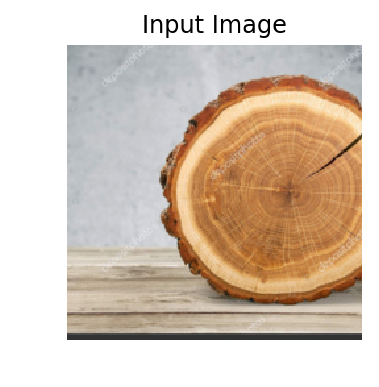

prob of NO CRACKS on the image: 0.00%
prob of CRACKS on the image: 100.00%
0.05606341361999512


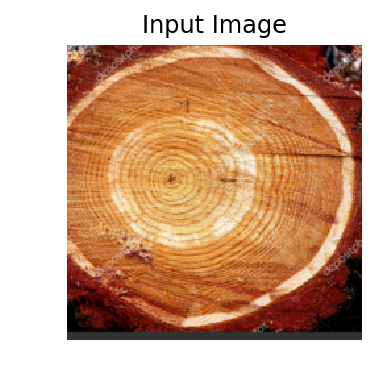

prob of NO CRACKS on the image: 99.98%
prob of CRACKS on the image: 0.02%


In [18]:
# path = './woodslabs/train/1/'
path = './woodslabs/2/2/'

for i in os.listdir(path):  
#     print(i)
    if('.jpeg' in i):
        image_path = path + str(i)
        check_sanity2(predict2(image_path, model, True))  
    else:
        print(f'{path + str(i)}: it\'s not an image file')

# probs, classses = get_predictions(image_path)
# probs, top_probs, top_idxs = predict(image_path, model)
# check_sanity2(probs)